<a href="https://colab.research.google.com/github/65-1157/Aplica-o_NLP_instrumentos_musicais/blob/main/5123_KNN_Instrumentos_Musicais_Andr%C3%A9_Marques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1_Preparação_ferramentas



Importação_bibliotecas





In [ ]:
import numpy as np
import itertools
# System
import os, fnmatch
# visualização
import seaborn 
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display
# Aprendizado_máquina
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
# Dados_aleatórios
from numpy.random import seed
seed(1)
# biblioteca_audio
import librosa.display, librosa

In [ ]:
# gerenciamento_alarmes
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# exibição_website
def show_web(url):
    html_code='<center><iframe src="%s" width="800" height="600" frameborder="0" marginheight="0" marginwidth="0">Loading...</iframe></center>' \
		% (url)
    display(HTML(html_code))

2_Dataset_Detalhes_Gerais

In [ ]:
# informação_geral_dataset
show_web("https://www.philharmonia.co.uk/resources/sound-samples/")


Arquivo_dataset_Phillarmonica

In [ ]:
!git clone https://github.com/GuitarsAI/BasicsMusicalInstrumClassifi
!unzip ./BasicsMusicalInstrumClassifi/audio/*.zip -d ./BasicsMusicalInstrumClassifi/audio
path="./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# pegar_audios
files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("encontrados %d audio_arquivos: %s"%(len(files),path))

fatal: destination path 'BasicsMusicalInstrumClassifi' already exists and is not an empty directory.
Archive:  ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi.zip
replace ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/mfcc_feature_vectors.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/mfcc_feature_vectors.pl  
replace ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/max_length.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
encontrados 600 audio_arquivos: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/


Carregar_nomes

In [ ]:
# Carregamento_identificação
labels =[]
classes=['flute','sax','oboe', 'cello','trumpet','viola']
color_dict={'cello':'blue', 'flute':'red', 'oboe':'green', 'trumpet':'black', 'sax':'magenta', 'viola':'yellow'}
color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

Atribuir_rótulos_labels

In [ ]:
# Alocação_labels_encoders
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

6 classes: cello, flute, oboe, sax, trumpet, viola


Parâmetros_processamento

In [ ]:
# Parâmetros
fs = 96000       # frequência_amostragem
n_fft = 2048      # janela_FFT_será_alterado
hop_length = 512  # Hop_será_alterado
n_mels = 128       # MEL bands_inalterado
n_mfcc = 13        # MFCCs_inalterado

# Geral_Aprendizado_Máquina
testset_size = 0.25 # Limite_corte_teste_treino
n_neighbors=1       # qte_vizinhos_será_alterado

Funções_cálculo

In [ ]:
# Cálculo: MFCC 
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,1)
    #feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector

In [ ]:
# Operação_dados_cálculo_features_feature vectors
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    print ("colhido %d de %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() # normalização pelo valor máximo (razão_será_<1)
        if len(y) < 2:
            print("Erro_carregamento %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Erro_carregamento %s. Error: %s" % (f,e))
        
print("Cálculos %d feature_vectors"%len(feature_vectors))

colhido 1 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_Gs6_05_forte_normal.mp3
colhido 2 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_A5_1_forte_normal.mp3
colhido 3 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_Gs4_025_pianissimo_normal.mp3
colhido 4 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_A4_15_pianissimo_normal.mp3
colhido 5 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_A5_05_pianissimo_normal.mp3
colhido 6 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_Gs5_05_mezzo-piano_normal.mp3
colhido 7 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_Gs4_025_mezzo-piano_normal.mp3
colhido 8 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_A5_025_pianissimo_normal.mp3
colhido 9 de 600 =

In [ ]:
# Alteração_dados_com_StandardScaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Formato_feature_vectors:",scaled_feature_vectors.shape)

Formato_feature_vectors: (600, 13)


Separação_treino_teste

In [ ]:
# Divisão_treino_teste: trocada a cada simulação
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [ ]:
# Confirmação_formatos_shapes: confirmado a cada simulação
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (450, 13)
test_set shape: (150, 13)
train_classes shape: (450,)
test_classes shape: (150,)


Classicador_KNN

In [ ]:
# Definição_KNN_model
n_neighbors= 100
model_knn = KNeighborsClassifier(n_neighbors=n_neighbors)

In [ ]:
# Ajuste_KNN
model_knn.fit(train_set, train_classes);

Predição

In [ ]:
# Aplicação_modelo_desenvolvido
predicted_labels = model_knn.predict(test_set)

Métricas

In [ ]:
# Recall - identificação_todos_positivos
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))
# Precision - identificação_discernimento_positivo_negativo
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))
# F1-Score - ponderação_recall_precision
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))
# Accuracy - quantidade_previsões_certas
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Número_amostras:",test_classes.shape[0])

Recall:  [0.92 0.72 0.64 0.56 0.96 0.88]
Precision:  [0.71875    0.69230769 0.84210526 0.93333333 0.70588235 0.91666667]
F1-Score:  [0.80701754 0.70588235 0.72727273 0.7        0.81355932 0.89795918]
Accuracy: 0.78  , 117
Número_amostras: 150


Matriz de Confusão

In [ ]:
# Execução_Matriz_Confusão
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

Plotagem_Matriz

In [ ]:
# Plotagem_Matriz_Confusão
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("matriz_confusão_normalizada")
    else:
        print('matriz_confusão_não_normalizada')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')

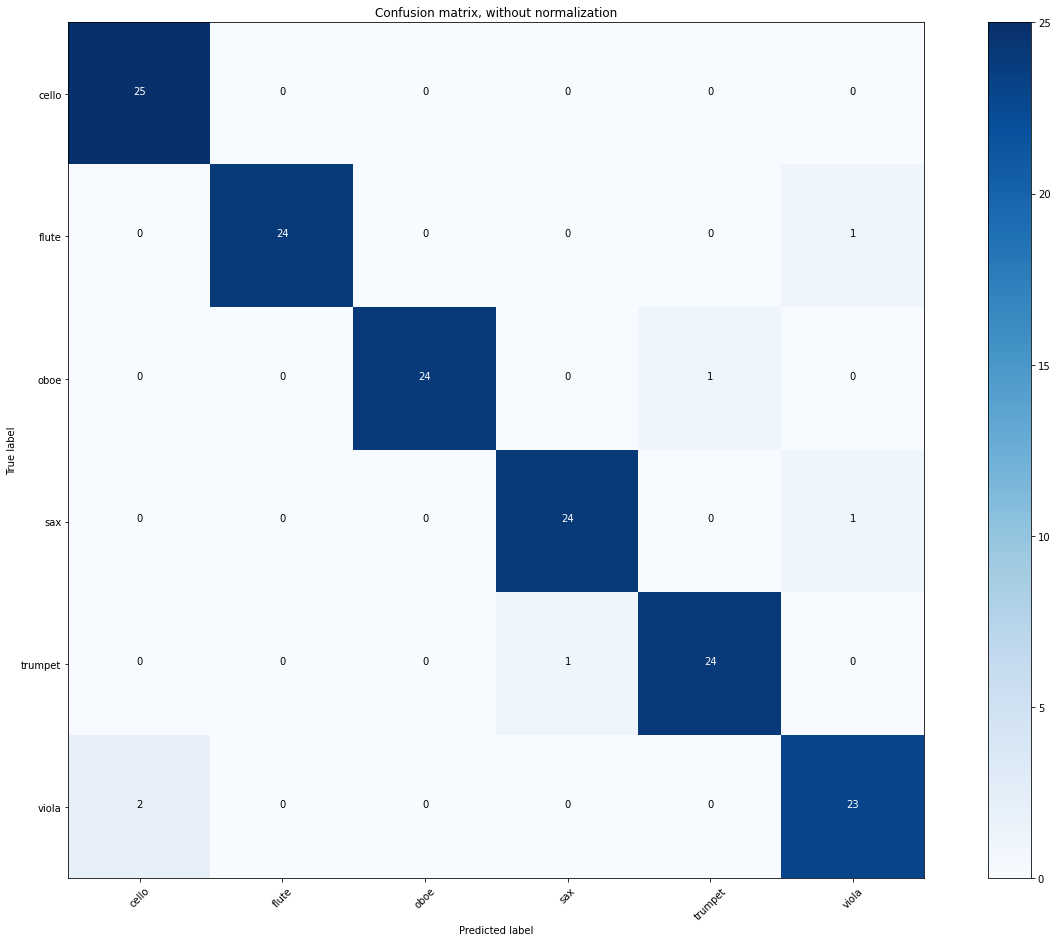

In [ ]:
# MC_não_normalizada
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='matriz_confusão_sem_normalização')

Valores_preditos_erroneamente

In [ ]:
# Exemplos_preditos_incorretamente
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [ ]:
# Predições_incorretas
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

['sax' 'sax' 'viola' 'oboe' 'oboe' 'cello' 'sax' 'sax' 'viola' 'viola'
 'cello']
[4 5 4 4 4 5 5 4 0 0 5]
['trumpet' 'viola' 'trumpet' 'trumpet' 'trumpet' 'viola' 'viola' 'trumpet'
 'cello' 'cello' 'viola']
['./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Ds5_1_forte_minor-trill.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Ds4_05_pianissimo_subtone.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_Gs5_1_fortissimo_snap-pizz.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/oboe/oboe_As3_15_mezzo-forte_normal.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/oboe/oboe_As3_1_mezzo-forte_normal.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/cello/cello_A4_1_mezzo-forte_arco-harmonic.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Gs3_05_pianissimo_normal.mp3'
 './BasicsMusicalInstrumCla